# Some insights into the ABO dataset

Decision questions:
- how many classes are enough ?
    - do we want a total control of the selected classes (verify that there is no overlap)?
- how many samples per class must be a minimum?
    - 17 (1 support set, 16 query set)?

In [4]:
from src.abo import ABO
from pathlib import Path
from torchvision import transforms
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from src.config import ROOT_FOLDER
import gzip
import json
from tqdm import tqdm

/home/sicara/.pyenv/versions/3.8.2/envs/fs-st/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root = Path("abo_dataset/images/small")
image_size = 112

dataset = ABO(
    root=root, 
    transform=transforms.Compose(
        [
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),)

## Classes

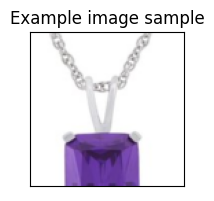

In [26]:
plt.figure(figsize=(2,2)), plt.xticks([]), plt.yticks([])
plt.imshow(dataset.__getitem__(2)[0].permute(1,2,0))
plt.title("Example image sample")
plt.show()

In [83]:
class_labels = dataset.get_labels()
class_labels_count = pd.Series(class_labels).value_counts()
class_labels_count_df = pd.DataFrame({'class_label': class_labels_count.index, 'count': class_labels_count.values})
print("Number of classes: ", len(class_labels_count_df))
print("Median number of samples per class: ", class_labels_count_df['count'].median())
print("Number of classes with more than 100 samples: ", len(class_labels_count_df[class_labels_count_df["count"]>=100]))

Number of classes:  573
Median number of samples per class:  16.0
Number of classes with more than 100 samples:  112


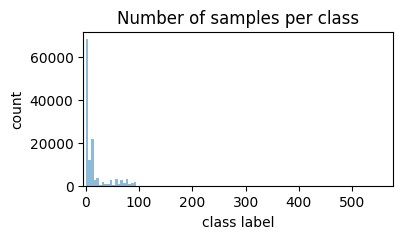

In [24]:
# fixed bin size
bins = np.arange(-100, 100, 5) # fixed bin size
plt.figure(figsize=(4,2)), plt.xlim([min(class_labels)-5, max(class_labels)+5])
plt.hist(class_labels, bins=bins, alpha=0.5)
plt.title('Number of samples per class'), plt.xlabel('class label'), plt.ylabel('count')

plt.show()

Observation:
- Classes 100 -> 600 have few number of samples
- Around a hundred of classes have huge amount of samples per class
### What are the classes with few number of samples? Are there doublon?

In [36]:
raw_dataset = pd.read_csv(ROOT_FOLDER / "data/gathered_abo_data.csv")
raw_dataset['label_count'] = raw_dataset.groupby('product_type')['product_type'].transform('count')
raw_dataset
#list(raw_dataset[raw_dataset['label_count']<17]['product_type'].unique())[:10]

,image_id,product_type,color,path,label_count
0,61JlaLwjT0L,HARDWARE_HANDLE,NaN,f2/f2ee3bf8.jpg,860
1,71XCjjPAQ3L,CELLULAR_PHONE_CASE,multi-colored,85/856b8e9e.jpg,64825
2,51TX65Xl7hL,NECKLACE,NaN,97/977a5359.jpg,457
3,71dxldZ4puL,CELLULAR_PHONE_CASE,multi-colored,62/62bc0963.jpg,64825
4,81TzZQMsWyL,CHAIR,NaN,55/555c2c68.jpg,2099
...,...,...,...,...,...
147122,71zMiY9KUHL,CELLULAR_PHONE_CASE,multi-colored,13/1336cc53.jpg,64825
147123,71Ncg7BnIbL,CELLULAR_PHONE_CASE,multi-colored,96/96d5f869.jpg,64825
147124,71a03l+eTQL,FRUIT,NaN,4d/4d25922c.jpg,97
147125,71yTCtZ4P3L,CELLULAR_PHONE_CASE,multi-colored,0e/0e164cf4.jpg,64825


Classes that may go together:
- 'NOTEBOOK_COMPUTER', 'COMPUTER', 'PERSONAL_COMPUTER'
- 'TOYS_AND_GAMES', 'GAME_DICE', 'TABLETOP_GAME', 'SPORT_TABLE_GAME'
- 'HAIR_CLEANER_CONDITIONER', 'HAIR_STYLING_AGENT', 'HAIR_REMOVAL_AGENT', 'HAIR_COLORING_AGENT'
- 'PRINT_COPY_PAPER', 'WRITING_PAPER'

## Colors

In [39]:
raw_dataset['color'] = raw_dataset['color'].astype(str)
raw_dataset['color_count'] = raw_dataset.groupby('color')['color'].transform('count')
raw_dataset

,image_id,product_type,color,path,label_count,color_count
0,61JlaLwjT0L,HARDWARE_HANDLE,nan,f2/f2ee3bf8.jpg,860,53896
1,71XCjjPAQ3L,CELLULAR_PHONE_CASE,multi-colored,85/856b8e9e.jpg,64825,63612
2,51TX65Xl7hL,NECKLACE,nan,97/977a5359.jpg,457,53896
3,71dxldZ4puL,CELLULAR_PHONE_CASE,multi-colored,62/62bc0963.jpg,64825,63612
4,81TzZQMsWyL,CHAIR,nan,55/555c2c68.jpg,2099,53896
...,...,...,...,...,...,...
147122,71zMiY9KUHL,CELLULAR_PHONE_CASE,multi-colored,13/1336cc53.jpg,64825,63612
147123,71Ncg7BnIbL,CELLULAR_PHONE_CASE,multi-colored,96/96d5f869.jpg,64825,63612
147124,71a03l+eTQL,FRUIT,nan,4d/4d25922c.jpg,97,53896
147125,71yTCtZ4P3L,CELLULAR_PHONE_CASE,multi-colored,0e/0e164cf4.jpg,64825,63612


In [85]:
color_count = raw_dataset['color'].value_counts()
color_count_df = pd.DataFrame({'color': color_count.index, 'count': color_count.values})
print("Number of different colors:", len(color_count_df))
color_count_df[color_count_df['count']>100].head(10)

Number of different colors: 558


,color,count
0,multi-colored,63612
1,nan,53896
2,Black,3527
3,Brown,2301
4,Blue,1954
5,Beige,1514
6,Grey,1180
7,Multi,870
8,White,846
9,black,807


In [11]:
from googletrans import Translator
translator = Translator()
print(translator.detect('rouge').lang)
print(translator.translate("rouge", dest='en').text, translator.translate("Blauw", dest='en', src='nl').text)

en
rouge Blue


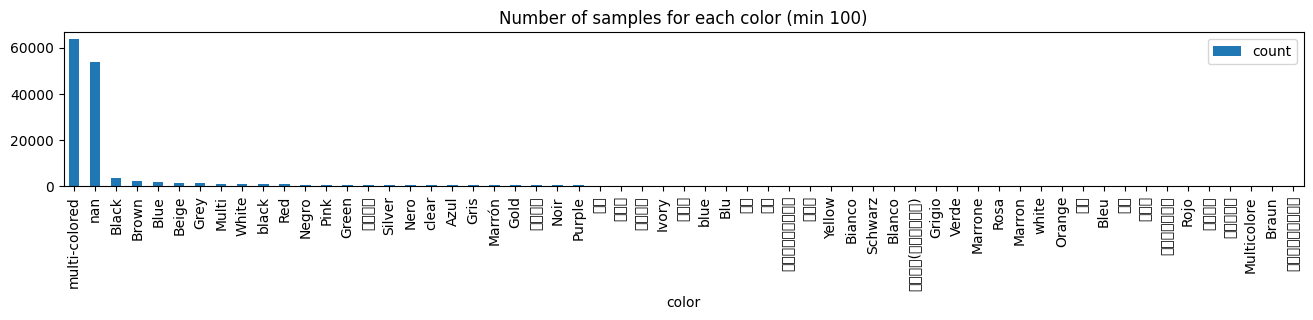

In [65]:
import warnings
warnings.filterwarnings("ignore")
color_count_df[color_count_df['count']>100].plot.bar(x='color', y='count', rot=90, figsize=(16,2), title="Number of samples for each color (min 100)")
plt.show()

Observations:
- some colors must be gathered: 'Black' & 'black', 'multi-colored' & 'multi', 'Grey' & 'Gris', etc:
    - use lower case
    - use language tag

### Colors with no standardized_value

In [5]:
json_files = list((ROOT_FOLDER / "abo_dataset/listings" / "metadata").iterdir())
color_list = []
language_list = []
for json_file in tqdm(json_files, desc="Metadata collection"):
    with gzip.open(f"{json_file}", "r") as f:
        data = [json.loads(line) for line in f]
    for product in data:
        if "main_image_id" in product and "color" in product:
            if "standardized_values" in product["color"][0]:
                #print(Translator(from_lang=product["color"][0]["language_tag"][:2],to_lang="en").translate(product["color"][0]["standardized_values"][0]))
                color_list.append(product["color"][0]["standardized_values"][0])
                language_list.append(product["color"][0]["language_tag"][:2])
            elif "value" in product["color"][0] and len(product["color"][0]["value"])>1:
                #Translator(from_lang=product["color"][0]["language_tag"][:2],to_lang="en").translate(product["color"][0]["value"][0])
                color_list.append(product["color"][0]["value"][0])
                language_list.append(product["color"][0]["language_tag"][:2])

Metadata collection: 100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


In [7]:
df_color = pd.DataFrame({'color': color_list, 'language': language_list})
df_color

,color,language
0,A,en
1,multi-colored,en
2,multi-colored,en
3,F,es
4,multi-colored,en
...,...,...
115714,multi-colored,en
115715,multi-colored,en
115716,multi-colored,en
115717,multi-colored,en


In [8]:
df_color['lower_case_color'] = df_color['color'].str.lower()

In [9]:
df_color[df_color.language == 'zh']

,color,language,lower_case_color
14,鞍,zh,鞍
39,灰,zh,灰
48,原,zh,原
57,黑,zh,黑
95,D,zh,d
...,...,...,...
115424,蓝色,zh,蓝色
115539,灰,zh,灰
115618,棕,zh,棕
115663,白,zh,白


In [10]:
df_color_with_count = df_color.groupby(['lower_case_color', 'language'])['lower_case_color'].count().reset_index(name="count")
df_color_with_count

,lower_case_color,language,count
0,#,en,51
1,(,de,1
2,(,en,9
3,(,es,6
4,(,fr,2
...,...,...,...
1135,퍼,ko,1
1136,퍼플,ko,10
1137,핑크,ko,11
1138,하얀색,ko,81


In [25]:
import re
import time

In [28]:
def translation_to_en(text, src_language):
    text = re.sub(r'[^a-zA-Z]', '', text)
    if len(text)>1:
        try:
            return translator.translate(text, dest='en', src=src_language).text
        except IndexError:
            try:
                print("index-try-except-try")
                return translator.translate(text, dest='en').text
            except:
                print("try-except-except", text, src_language)
                return np.nan
        except ValueError:
            # unknown src language
            try:
                print("value-try-except-try")
                return translator.translate(text, dest='en').text
            except:
                print("try-except-except", text, src_language)
                return np.nan
        except AttributeError as ae:
            # too many requests
            time.sleep(3)
            try:
                print("attribute-try-except-try")
                return translator.translate(text, dest='en', src=src_language).text
            except:
                print("try-except-except", ae, text, src_language)
                return np.nan

In [30]:
df_color_with_count['translated_color'] = df_color_with_count.apply(lambda row: translation_to_en(row.lower_case_color, row.language), axis=1)

attribute-try-except-try
attribute-try-except-try
try-except-except 'Translator' object has no attribute 'raise_Exception' grey en
attribute-try-except-try
try-except-except 'Translator' object has no attribute 'raise_Exception' purple de
attribute-try-except-try
try-except-except 'Translator' object has no attribute 'raise_Exception' blue de
attribute-try-except-try
try-except-except 'Translator' object has no attribute 'raise_Exception' rotlbkgultraschwer de
attribute-try-except-try
try-except-except 'Translator' object has no attribute 'raise_Exception' anthracite fr
attribute-try-except-try
try-except-except 'Translator' object has no attribute 'raise_Exception' anthrazit de
attribute-try-except-try
try-except-except 'Translator' object has no attribute 'raise_Exception' arancione it
attribute-try-except-try
attribute-try-except-try
attribute-try-except-try
try-except-except 'Translator' object has no attribute 'raise_Exception' azulmarino es
attribute-try-except-try
try-except-exc

In [17]:
df_color_with_count

,lower_case_color,language,count,translated_color
0,#,en,51,#
1,(,de,1,((
2,(,en,9,(
3,(,es,6,(
4,(,fr,2,(
...,...,...,...,...
1135,퍼,ko,1,fur
1136,퍼플,ko,10,purple
1137,핑크,ko,11,pink
1138,하얀색,ko,81,White
